#### Markov chain
$x_t$ is **categorical**, $x_t \in \{1, 2, ..., K\}$

> "distribution" of x is **probability mass function**
> $$
\pi_k \equiv  \Pr(x_t = k)
$$
>$$ \pi_{k}\in [0,1]$$
>$$\sum_k \pi_k = 1$$

Markovness means
$$
\Pr(x_t = k|x_{t-1} = i) = \pi_{ik}
$$
then (*) holds

#### Example
$x_{t} \in \{employed, unemployed\}$

Collect these values into a **transition matrix**
$$
\mathbf P = [\pi_{ik}]
$$
For ex,
$$
\begin{bmatrix}
0.7 & 0.3 \\
0.1 & 0.9
\end{bmatrix}
$$
#### Example
Employed people lose their job with prob 0.3. Unemployed find a job w prob 0.1.

> ### Remark
> Transition prob depend on time horizon.

> ### Properties
> $K\times K$ square
> $$
0 \le \mathbf P \le 1
$$
> $$
\mathbf P \mathbf 1 = \mathbf 1
$$
> (rows sum up to 1)


In [1]:
transition_matrix = [0.7 0.3; 0.1 0.9]

2×2 Matrix{Float64}:
 0.7  0.3
 0.1  0.9

Testing:

In [8]:
all(sum(transition_matrix, dims=2) .== 1)

true

In [5]:
sum(transition_matrix, dims=2) .== 1

2×1 BitMatrix:
 1
 1

In [10]:
all([false true false])

false

In [11]:
any([false true false])

true

In [15]:
transition_matrix .^ 2 == transition_matrix ^ 2

false

## Markov chain
1. Transition matrix $\mathbf P$
2. Starting state $x_0$
	1. more generally, $\pi_0 = \{\pi_{k0}\} = \Pr(x_0=k)$


In [69]:
struct MarkovChain
    P::Array{Float64, 2}
    π0::Vector{Float64}
    
    # check values of newly created MarkovChain objects
    function MarkovChain(P::Array{Float64, 2}, π0::Vector{Float64})
        # note the use of short-circuit "or" and "and" operators to catch error cases
        size(P, 1) != size(P, 2) && error("P is not square")
        size(π0, 1) != size(P, 2) && error("P is not the same size as π0")
        all((π0 .>= 0) .& (π0 .<= 1)) || error("π0 is not in [0,1]")
        all((P .>= 0) .& (P .<= 1)) || error("P is not in [0,1]")
        sum(π0) == 1.0 || error("π0 does not sum to 1")
        all(sum(P, dims=2) .== 1.0) || error("Ps rows do not sum to 1")

        # if all is good, return a new object
        return new(P, π0)
    end
end

### Forecasting
#### 1-period
$$
\Pr(x_1 = k|x_0 = j) = ? = [\mathbf P]_{jk}
$$
from a fixed state $j$, 
$$
\pi_1 = [\mathbf P]_{j.}
$$

> ### Example
> Probability being Employed vs Unemployed given Employed at time 0 
> $$
\begin{pmatrix}0.7  & 0.3\end{pmatrix}
$$

Starting from a distribution? Let's do a 2-period forecast
$$
\Pr(x_2 = k | x_0 = j)
= \sum_i
\Pr(x_2 = k | x_1 = i)
\Pr(x_1 = i | x_0 = j)
$$
$$
= \sum_i
[\mathbf P]_{ik}\pi_{1i} =
\pi_1'\mathbf P
$$
with $\pi_1$ a $K\times 1$ column vector

> ### Special case
> $\pi_1 = (0,...,0,1,0,...0) \equiv \mathbf e_j$
> $\mathbf e_j ' \mathbf P = \mathbf P_j$

> ### Example
> $$
\pi_{22} = 0.3\times 0.9 + 0.7\times 0.3 = 0.48
$$


### One-period ahead prediction
$$
\pi_t' \mathbf P = \pi_{t+1}'
$$
or
$$
\mathbf P'\pi_t  = \pi_{t+1}
$$


In [28]:
function forecast_markov_chain(mc::MarkovChain, T::Integer)::Array{Float64, 2}
    πprev = mc.π0
    output = zeros(length(mc.π0), T)
    for t = 1:T
        π = mc.P' * πprev
        # elementwise assignment is memory efficient
        output[:, t] .= π
        πprev = π
    end
    return output
    # show examples of Julia code
end

forecast_markov_chain (generic function with 2 methods)

In [72]:
unemployment_application = MarkovChain([0.7 0.3; 0.1 0.9], [1.0, 0.0])

MarkovChain([0.7 0.3; 0.1 0.9], [1.0, 0.0])

In [64]:
πt = forecast_markov_chain(unemployment_application, 30)

2×30 Matrix{Float64}:
 0.7  0.52  0.412  0.3472  0.30832  0.284992  …  0.250001  0.25  0.25  0.25
 0.3  0.48  0.588  0.6528  0.69168  0.715008     0.749999  0.75  0.75  0.75

In [65]:
length(unemployment_application.π0)

2

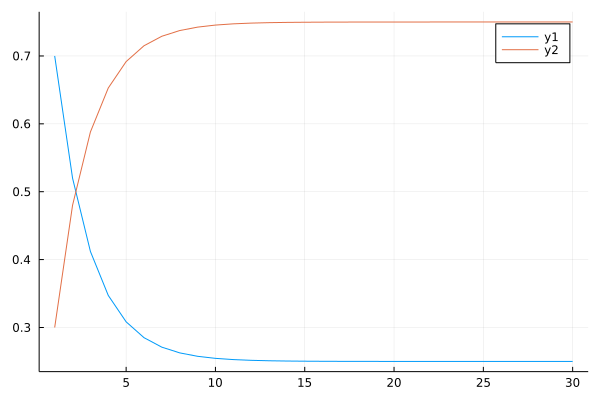

In [66]:
using Plots
plot(πt')

### Multiple periods
$$
\pi_t' = \pi_0' \mathbf P^t
$$
with matrix power
$$
\mathbf P^t = \mathbf P\cdot...\cdot \mathbf P
$$

## Steady state
Two definitions
(1) the very long run
$$
\pi_\infty = \lim_{t\to\infty} [\mathbf P']^t \pi_0
$$
(2) the steady state
$$
\pi_* = \mathbf P' \pi_*
$$

**Hopefully**
$$
\pi_\infty = \pi_*
$$
and unique

(2) is
$$
\pi_*(\mathbf I- \mathbf P') = 0
$$
i.e.
$\pi_*$ is the **eigenvector** corresponding to **eigenvalue** of 1.

1. $\mathbf P$ always has an eigenvalue of 1 (because its rows sum to 1). May be multiple. 
2. Eigenvector scaling is not a problem. If eigenvalue has multiplicity of 1 then $\pi_*$ is unique. (pmf pins down the scale)
3. In this case, $\pi_\infty =\pi_*$. (ergodicity) 

In [67]:
using LinearAlgebra
v = eigen(unemployment_application.P').vectors

2×2 Matrix{Float64}:
 -0.707107  -0.316228
  0.707107  -0.948683

In [68]:
v[:, 2] ./ sum(v[:, 2])

2-element Vector{Float64}:
 0.25
 0.7500000000000001

See [some real Julia code](https://github.com/JuliaStats/Distributions.jl/blob/master/src/multivariate/dirichletmultinomial.jl)